<a href="https://colab.research.google.com/github/DTA32/Paper_Research/blob/master/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Library Import
import time
import math
import random
import matplotlib.pyplot as plt

In [2]:
# Utility Library
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        return math.hypot(self.x - city.x, self.y - city.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"


def read_cities(size):
    cities = []
    with open(f'cities_{size}.data', 'r') as handle:
        lines = handle.readlines()
        for line in lines:
            x, y = map(float, line.split())
            cities.append(City(x, y))
    return cities

def path_cost(route):
    return sum([city.distance(route[index - 1]) for index, city in enumerate(route)])


def visualize_tsp(title, cities):
    fig = plt.figure()
    fig.suptitle(title)
    x_list, y_list = [], []
    for city in cities:
        x_list.append(city.x)
        y_list.append(city.y)
    x_list.append(cities[0].x)
    y_list.append(cities[0].y)

    plt.plot(x_list, y_list, 'ro')
    plt.plot(x_list, y_list, 'g')
    plt.show(block=True)

Algorithms Declaration

In [ ]:
# Greedy Algorithms
class Greedy:
    def __init__(self, cities):
        self.unvisited = cities[1:]
        self.route = [cities[0]]

    def run(self, plot):
        if plot:
            plt.ion()
            plt.show(block=False)
            self.init_plot()
        while len(self.unvisited):
            index, nearest_city = min(enumerate(self.unvisited),
                                      key=lambda item: item[1].distance(self.route[-1]))
            self.route.append(nearest_city)
            del self.unvisited[index]
            self.plot_interactive(False)
        self.route.append(self.route[0])
        self.plot_interactive(False)
        self.route.pop()
        return path_cost(self.route)

    def plot_interactive(self, block):
        x1, y1, x2, y2 = self.route[-2].x, self.route[-2].y, self.route[-1].x, self.route[-1].y
        plt.plot([x1, x2], [y1, y2], 'ro')
        plt.plot([x1, x2], [y1, y2], 'g')
        plt.draw()
        plt.pause(0.07)
        plt.show(block=block)

    def init_plot(self):
        fig = plt.figure(0)
        fig.suptitle('Greedy TSP')
        x_list, y_list = [], []
        for city in [*self.route, *self.unvisited]:
            x_list.append(city.x)
            y_list.append(city.y)
        x_list.append(self.route[0].x)
        y_list.append(self.route[0].y)

        plt.plot(x_list, y_list, 'ro')
        plt.show(block=False)

In [ ]:
# Simulated Annealing
class SimAnneal(object):
    def __init__(self, cities, temperature=-1, alpha=-1, stopping_temperature=-1, stopping_iter=-1):
        self.cities = cities
        self.num_cities = len(cities)
        self.temperature = math.sqrt(self.num_cities) if temperature == -1 else temperature
        self.T_save = self.temperature
        self.alpha = 0.999 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_temperature == -1 else stopping_temperature
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1
        self.route = None
        self.best_fitness = float("Inf")
        self.progress = []
        self.cur_cost = None

    def greedy_solution(self):
        start_node = random.randint(0, self.num_cities)  # start from a random node
        unvisited = self.cities[:]
        del unvisited[start_node]
        route = [cities[start_node]]
        while len(unvisited):
            index, nearest_city = min(enumerate(unvisited), key=lambda item: item[1].distance(route[-1]))
            route.append(nearest_city)
            del unvisited[index]
        current_cost = path_cost(route)
        self.progress.append(current_cost)
        return route, current_cost

    def accept_probability(self, candidate_fitness):
        return math.exp(-abs(candidate_fitness - self.cur_cost) / self.temperature)

    def accept(self, guess):
        guess_cost = path_cost(guess)
        if guess_cost < self.cur_cost:
            self.cur_cost, self.route = guess_cost, guess
            if guess_cost < self.best_fitness:
                self.best_fitness, self.route = guess_cost, guess
        else:
            if random.random() < self.accept_probability(guess_cost):
                self.cur_cost, self.route = guess_cost, guess

    def run(self):
        self.route, self.cur_cost = self.greedy_solution()
        while self.temperature >= self.stopping_temperature and self.iteration < self.stopping_iter:
            guess = list(self.route)
            left_index = random.randint(2, self.num_cities - 1)
            right_index = random.randint(0, self.num_cities - left_index)
            guess[right_index: (right_index + left_index)] = reversed(guess[right_index: (right_index + left_index)])
            self.accept(guess)
            self.temperature *= self.alpha
            self.iteration += 1
            self.progress.append(self.cur_cost)

        print("Best fitness obtained: ", self.best_fitness)

    def visualize_routes(self):
        visualize_tsp('simulated annealing TSP', self.route)

    def plot_learning(self):
        fig = plt.figure(1)
        plt.plot([i for i in range(len(self.progress))], self.progress)
        plt.ylabel("Distance")
        plt.xlabel("Iterations")
        plt.show(block=False)

In [3]:
# PSO
class Particle:
    def __init__(self, route, cost=None):
        self.route = route
        self.pbest = route
        self.current_cost = cost if cost else self.path_cost()
        self.pbest_cost = cost if cost else self.path_cost()
        self.velocity = []

    def clear_velocity(self):
        self.velocity.clear()

    def update_costs_and_pbest(self):
        self.current_cost = self.path_cost()
        if self.current_cost < self.pbest_cost:
            self.pbest = self.route
            self.pbest_cost = self.current_cost

    def path_cost(self):
        return path_cost(self.route)


class PSO:
    def __init__(self, iterations, population_size, gbest_probability=1.0, pbest_probability=1.0, cities=None):
        self.cities = cities
        self.gbest = None
        self.gcost_iter = []
        self.iterations = iterations
        self.population_size = population_size
        self.particles = []
        self.gbest_probability = gbest_probability
        self.pbest_probability = pbest_probability

        solutions = self.initial_population()
        self.particles = [Particle(route=solution) for solution in solutions]

    def random_route(self):
        return random.sample(self.cities, len(self.cities))

    def initial_population(self):
        random_population = [self.random_route() for _ in range(self.population_size - 1)]
        greedy_population = [self.greedy_route(0)]
        return [*random_population, *greedy_population]
        # return [*random_population]

    def greedy_route(self, start_index):
        unvisited = self.cities[:]
        del unvisited[start_index]
        route = [self.cities[start_index]]
        while len(unvisited):
            index, nearest_city = min(enumerate(unvisited), key=lambda item: item[1].distance(route[-1]))
            route.append(nearest_city)
            del unvisited[index]
        return route

    def run(self):
        self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
        print(f"initial cost is {self.gbest.pbest_cost}")
        # plt.ion()
        # plt.draw()
        for t in range(self.iterations):
            self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
            # if t % 20 == 0:
            #     plt.figure(0)
            #     plt.plot(pso.gcost_iter, 'g')
            #     plt.ylabel('Distance')
            #     plt.xlabel('Generation')
            #     fig = plt.figure(0)
            #     fig.suptitle('pso iter')
            #     x_list, y_list = [], []
            #     for city in self.gbest.pbest:
            #         x_list.append(city.x)
            #         y_list.append(city.y)
            #     x_list.append(pso.gbest.pbest[0].x)
            #     y_list.append(pso.gbest.pbest[0].y)
            #     fig = plt.figure(1)
            #     fig.clear()
            #     fig.suptitle(f'pso TSP iter {t}')

            #     plt.plot(x_list, y_list, 'ro')
            #     plt.plot(x_list, y_list, 'g')
            #     plt.draw()
            #     plt.pause(.001)
            self.gcost_iter.append(self.gbest.pbest_cost)

            for particle in self.particles:
                particle.clear_velocity()
                temp_velocity = []
                gbest = self.gbest.pbest[:]
                new_route = particle.route[:]

                for i in range(len(self.cities)):
                    if new_route[i] != particle.pbest[i]:
                        swap = (i, particle.pbest.index(new_route[i]), self.pbest_probability)
                        temp_velocity.append(swap)
                        new_route[swap[0]], new_route[swap[1]] = \
                            new_route[swap[1]], new_route[swap[0]]

                for i in range(len(self.cities)):
                    if new_route[i] != gbest[i]:
                        swap = (i, gbest.index(new_route[i]), self.gbest_probability)
                        temp_velocity.append(swap)
                        gbest[swap[0]], gbest[swap[1]] = gbest[swap[1]], gbest[swap[0]]

                particle.velocity = temp_velocity

                for swap in temp_velocity:
                    if random.random() <= swap[2]:
                        new_route[swap[0]], new_route[swap[1]] = \
                            new_route[swap[1]], new_route[swap[0]]

                particle.route = new_route
                particle.update_costs_and_pbest()



Algorithms Execution

In [ ]:
# Determining Dataset
cities = read_cities(657)

In [ ]:
# Greedy
greedy = Greedy(cities)
start = time.time()
print("Started at", start)

print(greedy.run(plot=True))
    
end = time.time()
print("Ended at", end)
print("Interval is", round(end-start,3))

print(greedy.route)
plt.show(block=True)

In [ ]:
# Simulated Annealing
sa = SimAnneal(cities, stopping_iter=30000)

start = time.time()
print("Started at", start)

sa.run()

end = time.time()
print("Ended at", end)
print("Interval is", round(end-start,3))
print("Iteration:", sa.iteration)

sa.plot_learning()
sa.visualize_routes()

In [ ]:
# PSO (EIL76)
    pso = PSO(iterations=1000, population_size=150, pbest_probability=0.9, gbest_probability=0.01, cities=cities)

    start = time.time()
    print("Started at", start)

    pso.run()

    end = time.time()
    print("Ended at", end)
    print("Interval is", round(end-start,3))

    print(f'cost: {pso.gbest.pbest_cost}\t| gbest: {pso.gbest.pbest}')
    print("Iteration:", pso.iterations)

    x_list, y_list = [], []
    for city in pso.gbest.pbest:
        x_list.append(city.x)
        y_list.append(city.y)
    x_list.append(pso.gbest.pbest[0].x)
    y_list.append(pso.gbest.pbest[0].y)
    fig = plt.figure(1)
    fig.suptitle('pso TSP')

    plt.plot(x_list, y_list, 'ro')
    plt.plot(x_list, y_list)
    plt.show(block=True)



Started at 1686507726.904813
initial cost is 62176.401032322225
Ended at 1686508494.1494343
Interval is 767.245
cost: 62155.85239182358	| gbest: [(0.0, 0.0), (875.1, 983.7), (887.8, 1040.9), (875.1, 1136.1), (1014.8, 1148.8), (1052.9, 1136.1), (1014.8, 1059.9), (1116.4, 1059.9), (1167.2, 1015.5), (1249.7, 1117.1), (1306.9, 1110.7), (1345.0, 1034.5), (1370.4, 1053.6), (1433.9, 1059.9), (1465.6, 1059.9), (1497.4, 1040.9), (1548.2, 1059.9), (1586.3, 1059.9), (1630.7, 1021.8), (1668.8, 1015.5), (1751.4, 971.0), (1789.5, 996.4), (1764.1, 1028.2), (1776.8, 1053.6), (1738.7, 1085.3), (1713.3, 1110.7), (1751.4, 1136.1), (1726.0, 1161.5), (1700.6, 1174.2), (1706.9, 1212.3), (1624.4, 1186.9), (1624.4, 1110.7), (1433.9, 1098.0), (1427.5, 1174.2), (1503.7, 1288.5), (1433.9, 1339.3), (1402.1, 1364.7), (1383.1, 1333.0), (1325.9, 1307.6), (1306.9, 1320.3), (1268.8, 1402.8), (1243.4, 1428.2), (1249.7, 1479.0), (1256.1, 1504.4), (1268.8, 1523.5), (1294.2, 1491.7), (1313.2, 1567.9), (1338.6, 1593.3), (1

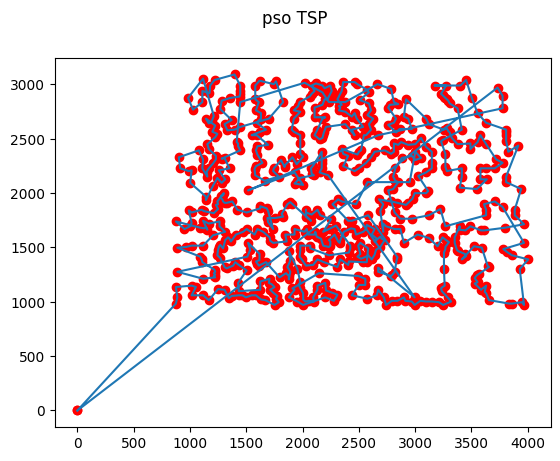

In [5]:
    # PSO (D657)
    pso = PSO(iterations=2000, population_size=500, pbest_probability=0.9, gbest_probability=0.01, cities=cities)
    
    start = time.time()
    print("Started at", start)

    pso.run()

    end = time.time()
    print("Ended at", end)
    print("Interval is", round(end-start,3))
    
    print(f'cost: {pso.gbest.pbest_cost}\t| gbest: {pso.gbest.pbest}')
    print("Iteration:", pso.iterations)

    x_list, y_list = [], []
    for city in pso.gbest.pbest:
        x_list.append(city.x)
        y_list.append(city.y)
    x_list.append(pso.gbest.pbest[0].x)
    y_list.append(pso.gbest.pbest[0].y)
    fig = plt.figure(1)
    fig.suptitle('pso TSP')

    plt.plot(x_list, y_list, 'ro')
    plt.plot(x_list, y_list)
    plt.show(block=True)
